<a href="https://www.kaggle.com/code/faizanaliabdulali/skeleton-matching?scriptVersionId=182822172" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [15]:
!pip install rembg==2.0.56 -q

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rembg import new_session, remove
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
class ImageModel:
    def __init__(self, rgb_img, mask_img, cropped_mask=None, cropped_feature=None, key_contour=None):
        self.rgb_img = rgb_img                 # Original Img (RGB)
        self.mask_img = mask_img               # Orignal Img Mask (Binary)
        self.cropped_mask = cropped_mask       # Cropped Mask (Rotated + Binary)
        self.cropped_feature = cropped_feature # Cropped Feature (Rotated + Grayscale)
        self.key_contour = key_contour         # Key Contour

def fix_image_size(image):
    PADDING = 12
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    dimension = max(original_height, original_width)

    # Create a blank canvas of the desired size
    canvas = np.zeros((dimension, dimension), dtype=np.uint8)

    # Calculate the offset to center the image on the canvas
    offset_x = (canvas.shape[1] - image.shape[1]) // 2
    offset_y = (canvas.shape[0] - image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+image.shape[0], offset_x:offset_x+image.shape[1]] = image

    return canvas


def resize_grayscale_image_to_256x256(image):
    WIDTH = 232
    HEIGHT = 232
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_grayscale_image(image, DIMENSION)


def resize_grayscale_image(image, dimension):
    WIDTH, HEIGHT, PADDING = dimension
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the scaling factor for both dimensions
    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    # Choose the smaller scaling factor to maintain aspect ratio
    scale = min(scale_x, scale_y)

    # Resize the image using the calculated scaling factor
    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    # Create a blank canvas of the desired size
    canvas = np.zeros((HEIGHT + 2*PADDING, WIDTH + 2*PADDING), dtype=np.uint8)

    # Calculate the offset to center the resized image on the canvas
    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+resized_image.shape[0], offset_x:offset_x+resized_image.shape[1]] = resized_image
    
    return canvas


def is_ellipse_center_below_lower_half(center, image_shape):
    center_x, center_y = center
    image_width, image_height = image_shape
    return True if (center_y > image_height / 2) else False


def get_rotation_angle(is_below, current_angle):
    new_angle = 0
    if current_angle < 90:
        new_angle = 90 + current_angle
    elif current_angle > 90 and current_angle < 180:
        new_angle = current_angle - 90
    
    return (new_angle + 180) if is_below else (new_angle + 180)

def image_processing_pipeline(image_path):
    # 1. Read img as RGB
    rgb_img = np.array(image_path)

    # 2. Convert RGB to Grayscale and create an empty img of same dimension
    grayscale_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    empty_img = np.zeros_like(grayscale_img, dtype=np.uint8)

    # 3. Convert rgb to mask
    grayscale_mask = remove_bg(rgb_img, only_mask=True)

    # 4. Convert masked image to binary mask
    grayscale_mask = np.array(grayscale_mask)
    _, mask_img = cv2.threshold(grayscale_mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Cropped masked img
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_mask = mask_img[y:y+h, x:x+w]

    # 6. Extract and paste only region of interest to grayscale image
    thickness = int((rgb_img.shape[0] + rgb_img.shape[1]) / 200)
    cv2.drawContours(empty_img, contours, -1, (255), thickness=thickness)
    cropped_feature = cv2.bitwise_and(grayscale_img, grayscale_img, mask=empty_img)

    # 7. Make model object
    img_model = ImageModel(rgb_img=np.array(rgb_img),
                           mask_img=mask_img,
                           cropped_mask=cropped_mask, # Useless
                           cropped_feature=cropped_feature, # Useless right now
                           key_contour=contours[0])
    
    # 8. Rotate key inside the image by fitting ellipse
    ellipse = cv2.fitEllipse(img_model.key_contour)
    center, axis_lengths, current_angle = ellipse
    is_below = is_ellipse_center_below_lower_half(center, img_model.mask_img.shape)
    rotation_angle = get_rotation_angle(is_below, current_angle)

    # 9. Resize mask and grayscale image before applying rotation
    resized_binary_image = fix_image_size(img_model.mask_img)
    resized_grayscale_image = fix_image_size(img_model.cropped_feature)

    # 10. Apply rotation
    center = (resized_binary_image.shape[1] // 2, resized_binary_image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    rotated_binary_image = cv2.warpAffine(resized_binary_image, rot_mat, resized_binary_image.shape[1::-1])
    rotated_grayscale_image = cv2.warpAffine(resized_grayscale_image, rot_mat, resized_grayscale_image.shape[1::-1])

    # 11. Cropped the rotated masked img
    contours, _ = cv2.findContours(rotated_binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    rotated_binary_image = rotated_binary_image[y:y+h, x:x+w]
    rotated_grayscale_image = rotated_grayscale_image[y:y+h, x:x+w]

    # 12. Updated cropped masked
    img_model.cropped_mask = rotated_binary_image
    img_model.cropped_feature = rotated_grayscale_image
    
    # 13. Resized cropped feature t0 256x256
    rezised_feature = resize_grayscale_image_to_256x256(img_model.cropped_feature)
    
    return rezised_feature

def remove_bg(input_img, only_mask=False):
    '''
    Remove background for single images
    '''
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    output_img = remove(input_img,
                        session=session_isnet_general_use,
                        only_mask=only_mask)
    return output_img


def load_general_use_model(model_name='isnet-general-use'):
    '''
    Parameters:
    model_name: str
    '''
    session = new_session(model_name)
    return session


def plt_contour(contour):
    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Create an empty black image with dimensions based on the bounding box
    blank_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Draw the contour on the black image with the contour shifted to the top-left corner of the bounding box
    shifted_contour = contour - np.array([x, y])
    contour_image = cv2.drawContours(blank_image, [shifted_contour], -1, (0, 0, 255), thickness=cv2.FILLED)
    
    plt_img(contour_image)
    
    
def draw_ellipse(rgb_img, ellipse):
    center, axis_lengths, current_angle = ellipse
    
    # Draw the ellipse on the image
    cv2.ellipse(rgb_img, ellipse, (0, 255, 0), 5)

    # Draw the center of the ellipse
    center_point = (int(center[0]), int(center[1]))
    cv2.circle(rgb_img, center_point, 20, (255, 0, 0), 20)

    # Draw the axis lengths (major and minor axes)
    major_axis_length = axis_lengths[1] / 2
    minor_axis_length = axis_lengths[0] / 2
    
    # Convert angles to radians for calculation
    angle_rad = np.deg2rad(current_angle)
    perpendicular_angle_rad = angle_rad + np.pi / 2

    # Calculate the endpoints of the major axis
    major_axis_x = int(center[0] + major_axis_length * np.cos(angle_rad))
    major_axis_y = int(center[1] + major_axis_length * np.sin(angle_rad))
    cv2.line(rgb_img, center_point, (major_axis_x, major_axis_y), (0, 0, 255), 10)

    # Calculate the endpoints of the minor axis
    minor_axis_x = int(center[0] - minor_axis_length * np.sin(angle_rad))
    minor_axis_y = int(center[1] + minor_axis_length * np.cos(angle_rad))
    cv2.line(rgb_img, center_point, (minor_axis_x, minor_axis_y), (0, 0, 255), 10)
    
    # Calculate the rotation matrix
    rotation_angle = -current_angle
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Get the dimensions of the image
    (h, w) = img_model.rgb_img.shape[:2]

    # Apply the rotation to the image
    rotated_img = cv2.warpAffine(img_model.rgb_img, rotation_matrix, (w, h))

    return rgb_img, rotated_img


def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()

In [18]:
filepaths, images = [], []
BASE_PATH = '/kaggle/input/key-images/'

for filename in os.listdir(BASE_PATH):
    if filename[0].isdigit():
        path = os.path.join(BASE_PATH, filename)
        filepaths.append(path)
        
filepaths.sort()
filepaths = filepaths[9:]

for filepath in filepaths:
    images.append(cv2.imread(filepath))

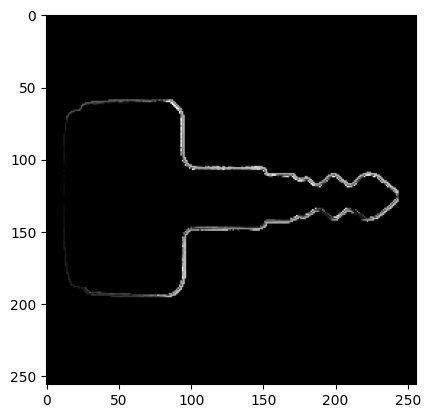

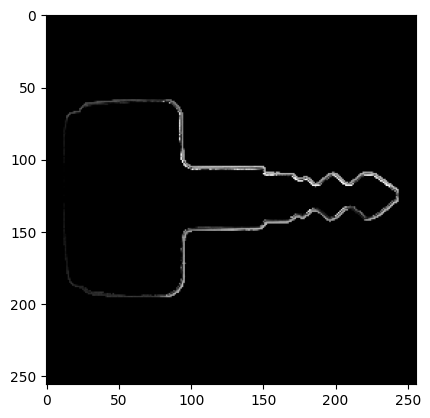

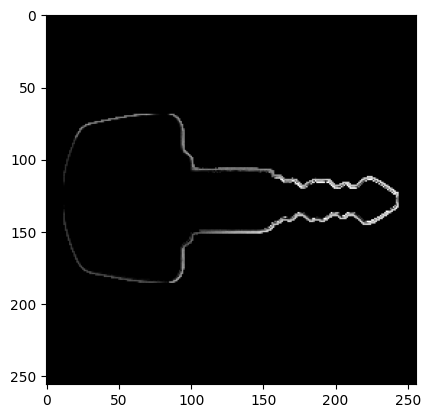

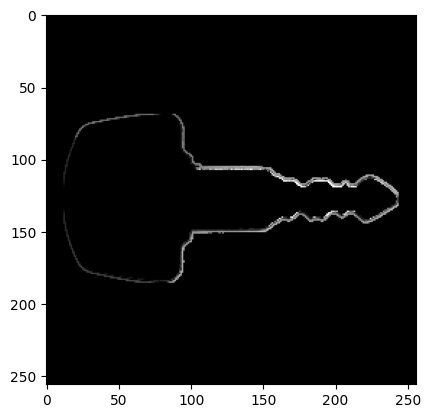

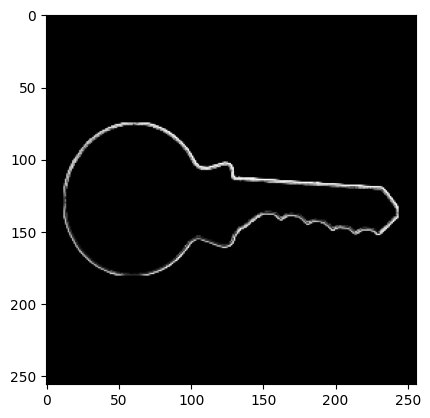

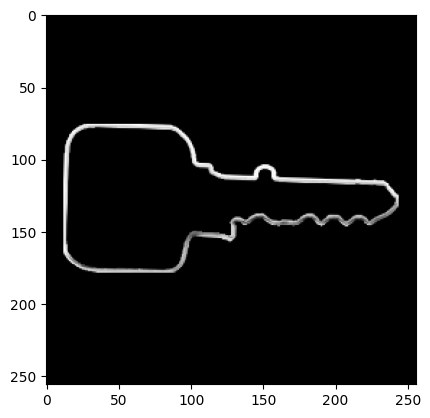

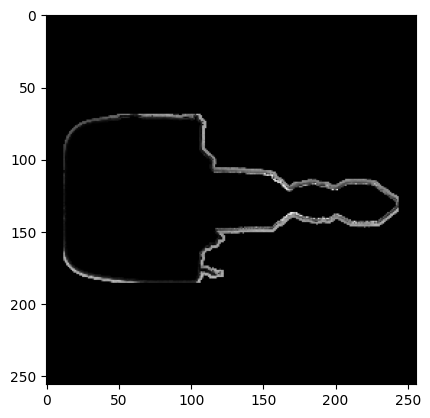

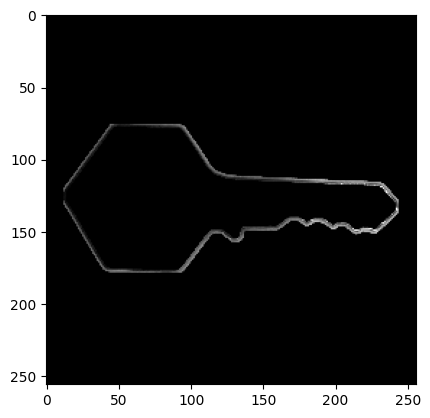

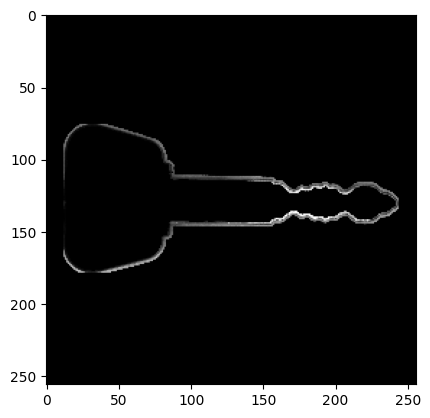

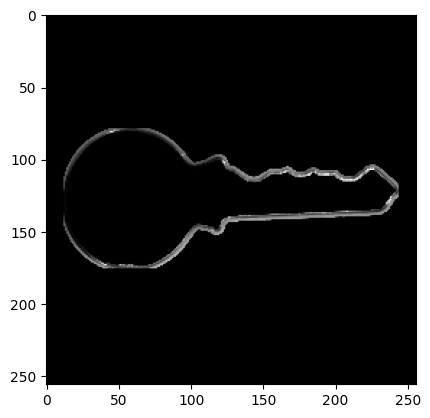

In [19]:
skeletons = []

for image in images:
    skeleton = image_processing_pipeline(image)
    plt_img(skeleton, cmap="gray")
    skeletons.append(skeleton)

In [20]:
def plot_confusion_matrix(images_data, index_array):
    
    num_images = len(images_data)
    confusion_matrix = np.zeros((num_images, num_images))

    for i in range(num_images):
        for j in range(num_images):
            flat_img1 = images_data[i].flatten().reshape(1, -1)
            flat_img2 = images_data[j].flatten().reshape(1, -1)

            cosine_sim = cosine_similarity(flat_img1, flat_img2)[0][0]

            confusion_matrix[i, j] = cosine_sim

    df_confusion_matrix = pd.DataFrame(confusion_matrix, 
                                       index=index_array, 
                                       columns=index_array)
    return df_confusion_matrix

indexes = [path.split('/')[-1] for path in filepaths]

plot_confusion_matrix(skeletons, indexes)

,1a.jpeg,1b.jpeg,2a.jpeg,2b.jpeg,3.jpeg,4.jpeg,5.jpg,7.jpg,8.jpg,9.jpg
1a.jpeg,1.000000,0.744194,0.267078,0.368995,0.101496,0.204817,0.179074,0.125534,0.120506,0.205633
1b.jpeg,0.744194,1.000000,0.242173,0.363922,0.106301,0.196700,0.198919,0.125900,0.106183,0.229344
2a.jpeg,0.267078,0.242173,1.000000,0.687958,0.161789,0.312698,0.353875,0.223644,0.227213,0.125094
2b.jpeg,0.368995,0.363922,0.687958,1.000000,0.176689,0.306021,0.286157,0.198483,0.157286,0.162837
3.jpeg,0.101496,0.106301,0.161789,0.176689,1.000000,0.244398,0.158877,0.238097,0.165059,0.153252
4.jpeg,0.204817,0.196700,0.312698,0.306021,0.244398,1.000000,0.224076,0.351409,0.228729,0.154135
5.jpg,0.179074,0.198919,0.353875,0.286157,0.158877,0.224076,1.000000,0.253320,0.276006,0.117131
7.jpg,0.125534,0.125900,0.223644,0.198483,0.238097,0.351409,0.253320,1.000000,0.135173,0.075703
8.jpg,0.120506,0.106183,0.227213,0.157286,0.165059,0.228729,0.276006,0.135173,1.000000,0.158382
9.jpg,0.205633,0.229344,0.125094,0.162837,0.153252,0.154135,0.117131,0.075703,0.158382,1.000000
